# Analysis on the google playstore data set

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle."></form>''')

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline
from plotly.offline import iplot
import plotly.figure_factory as ff

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.simplefilter("ignore")


## Importing the dataset

In [2]:
#importing the dataset
df = pd.read_csv("google.csv")
#print("df = pd.read_csv('google.csv')")
print("Total number of rows in the dataset -",len(df))
df = df.drop(df.index[9148])
df.drop_duplicates(subset='App', inplace=True)
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']


print("Number of rows after dropping the duplicates -",len(df))
#df.drop_duplicates(subset='App',inplace=True)

Total number of rows in the dataset - 10841
Number of rows after dropping the duplicates - 9658


# The dataset

In [3]:
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


## DATA CLEANING

In [4]:
df.drop(columns=['Last Updated', 'Current Ver', 'Android Ver'],inplace = True)
df.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity


### SIZE 


The Size table initially looks as follows

In [5]:
df['Size']

0                       19M
1                       14M
2                      8.7M
3                       25M
4                      2.8M
                ...        
10836                   53M
10837                  3.6M
10838                  9.5M
10839    Varies with device
10840                   19M
Name: Size, Length: 9658, dtype: object

We eliminate the special characters '+' and ','. We also remove the units i.e 'M' and 'k'
We also convert the values to float.

The size column after the transformation looks as follows.

In [6]:
df['Size'] = df['Size'].replace('1,000+',1000)
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].astype(float)
df['Size']


0        19.0
1        14.0
2         8.7
3        25.0
4         2.8
         ... 
10836    53.0
10837     3.6
10838     9.5
10839     NaN
10840    19.0
Name: Size, Length: 9658, dtype: float64

===========================================================================

### INSTALLS

Installs table before transformation. we observe it has commas and plus signs.

In [7]:
df.Installs

0            10,000+
1           500,000+
2         5,000,000+
3        50,000,000+
4           100,000+
            ...     
10836         5,000+
10837           100+
10838         1,000+
10839         1,000+
10840    10,000,000+
Name: Installs, Length: 9658, dtype: object

We remove the '+' signs and the ',' from every entry and convert object type to float.
This is how the updated installs column appears.

In [8]:
df.Installs=df.Installs.apply(lambda x: x.strip('+'))
df.Installs=df.Installs.apply(lambda x: x.replace(',',''))
df.Installs=df.Installs.replace('Free',np.nan)
df.Installs = df.Installs.astype(float)
df.Installs



0           10000.0
1          500000.0
2         5000000.0
3        50000000.0
4          100000.0
            ...    
10836        5000.0
10837         100.0
10838        1000.0
10839        1000.0
10840    10000000.0
Name: Installs, Length: 9658, dtype: float64

==================================================================

### REVIEWS

This column denotes the number of reviews for every application. We replace the non numeric values with 'NaN' and convert the type to int

In [9]:
df.Reviews=df.Reviews.replace([~df.Reviews.str.isnumeric()],"NaN")
df.Reviews = df.Reviews.astype(int)
df['Reviews']

0           159
1           967
2         87510
3        215644
4           967
          ...  
10836        38
10837         4
10838         3
10839       114
10840    398307
Name: Reviews, Length: 9658, dtype: int32

Number of reviews for every application

===========================================================================

### RATINGS

In [10]:
print("Range of ratings: ", df.Rating.min(),"-",df.Rating.max())

Range of ratings:  1.0 - 5.0


In [11]:
print(df.Rating.isna().sum(),"null values out of", len(df.Rating))

1462 null values out of 9658


1462 values are null values. Since Ratings is an important parameter we can drop those rows as it will cause a bias within the model.
There we used the 'FFILL' method for fillig the null values with the values of the previous rows.

In [12]:
df.Rating.fillna(method = "ffill")

0        4.1
1        3.9
2        4.7
3        4.5
4        4.3
        ... 
10836    4.5
10837    5.0
10838    5.0
10839    4.5
10840    4.5
Name: Rating, Length: 9658, dtype: float64

The ratings column after transformation.

### TYPE

In [13]:
df.Type.value_counts()

Free    8902
Paid     756
Name: Type, dtype: int64

The Sum of free and paid apps equals 9658 which is the length of the dataset indicating that there is no incorrect data in the type column.
This column needs no transformation or corrections.

In [14]:
df.Type

0        Free
1        Free
2        Free
3        Free
4        Free
         ... 
10836    Free
10837    Free
10838    Free
10839    Free
10840    Free
Name: Type, Length: 9658, dtype: object

============================================================================

### PRICE

The price column has '$' sign to denote the currency. We remove the sign from every entry.

In [15]:
df.Price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [16]:
df.Price=df.Price.apply(lambda x: x.strip('$'))
df.Price = df.Price.astype(float)

The updated Price column - 

In [17]:
df.Price.unique()

array([  0.  ,   4.99,   3.99,   6.99,   1.49,   2.99,   7.99,   5.99,
         3.49,   1.99,   9.99,   7.49,   0.99,   9.  ,   5.49,  10.  ,
        24.99,  11.99,  79.99,  16.99,  14.99,   1.  ,  29.99,  12.99,
         2.49,  10.99,   1.5 ,  19.99,  15.99,  33.99,  74.99,  39.99,
         3.95,   4.49,   1.7 ,   8.99,   2.  ,   3.88,  25.99, 399.99,
        17.99, 400.  ,   3.02,   1.76,   4.84,   4.77,   1.61,   2.5 ,
         1.59,   6.49,   1.29,   5.  ,  13.99, 299.99, 379.99,  37.99,
        18.99, 389.99,  19.9 ,   8.49,   1.75,  14.  ,   4.85,  46.99,
       109.99, 154.99,   3.08,   2.59,   4.8 ,   1.96,  19.4 ,   3.9 ,
         4.59,  15.46,   3.04,   4.29,   2.6 ,   3.28,   4.6 ,  28.99,
         2.95,   2.9 ,   1.97, 200.  ,  89.99,   2.56,  30.99,   3.61,
       394.99,   1.26,   1.2 ,   1.04])

In [18]:
df.Price.dtype

dtype('float64')

We observe that there are some applications over 200 dollars shown below

In [19]:
temp=df.Price.apply(lambda x: True if float(x) >= 200 else False)
df[temp]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
4197,most expensive app (H),FAMILY,4.3,6,1.500,100.0,Paid,399.99,Everyone,Entertainment
4362,💎 I'm rich,LIFESTYLE,3.8,718,26.000,10000.0,Paid,399.99,Everyone,Lifestyle
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.300,10000.0,Paid,400.00,Everyone,Lifestyle
5351,I am rich,LIFESTYLE,3.8,3547,1.800,100000.0,Paid,399.99,Everyone,Lifestyle
5354,I am Rich Plus,FAMILY,4.0,856,8.700,10000.0,Paid,399.99,Everyone,Entertainment
5355,I am rich VIP,LIFESTYLE,3.8,411,2.600,10000.0,Paid,299.99,Everyone,Lifestyle
5356,I Am Rich Premium,FINANCE,4.1,1867,4.700,50000.0,Paid,399.99,Everyone,Finance
5357,I am extremely Rich,LIFESTYLE,2.9,41,2.900,1000.0,Paid,379.99,Everyone,Lifestyle
5358,I am Rich!,FINANCE,3.8,93,22.000,1000.0,Paid,399.99,Everyone,Finance
5359,I am rich(premium),FINANCE,3.5,472,0.965,5000.0,Paid,399.99,Everyone,Finance


These are non functional status quo applications. These are junk applications that cause unnecessary bias in the model.
Therefore we drop these rows from the dataset later.

=====================================================================================

### CATEGORY

All categories of apps in the dataset

In [20]:
df.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

### CONTENT RATING

Content ratings of applications of apps across the playstore

In [21]:
df["Content Rating"].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

In [22]:
df["Content Rating"].value_counts()

Everyone           7903
Teen               1036
Mature 17+          393
Everyone 10+        321
Adults only 18+       3
Unrated               2
Name: Content Rating, dtype: int64

Since the summation adds up to the total number of entries in the dataset it is clear that there is no incorrect data in the content ratign column.

## The Dataset after transformation

In [23]:
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity
...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,5000.0,Free,0.0,Everyone,Education
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100.0,Free,0.0,Everyone,Education
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5,1000.0,Free,0.0,Everyone,Medical
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,NaN,1000.0,Free,0.0,Mature 17+,Books & Reference


### This is the final representation of the dataset after the cleaning and pre-processing.

# EDA ON THE DATASET

### Pairplot of all numeric relations

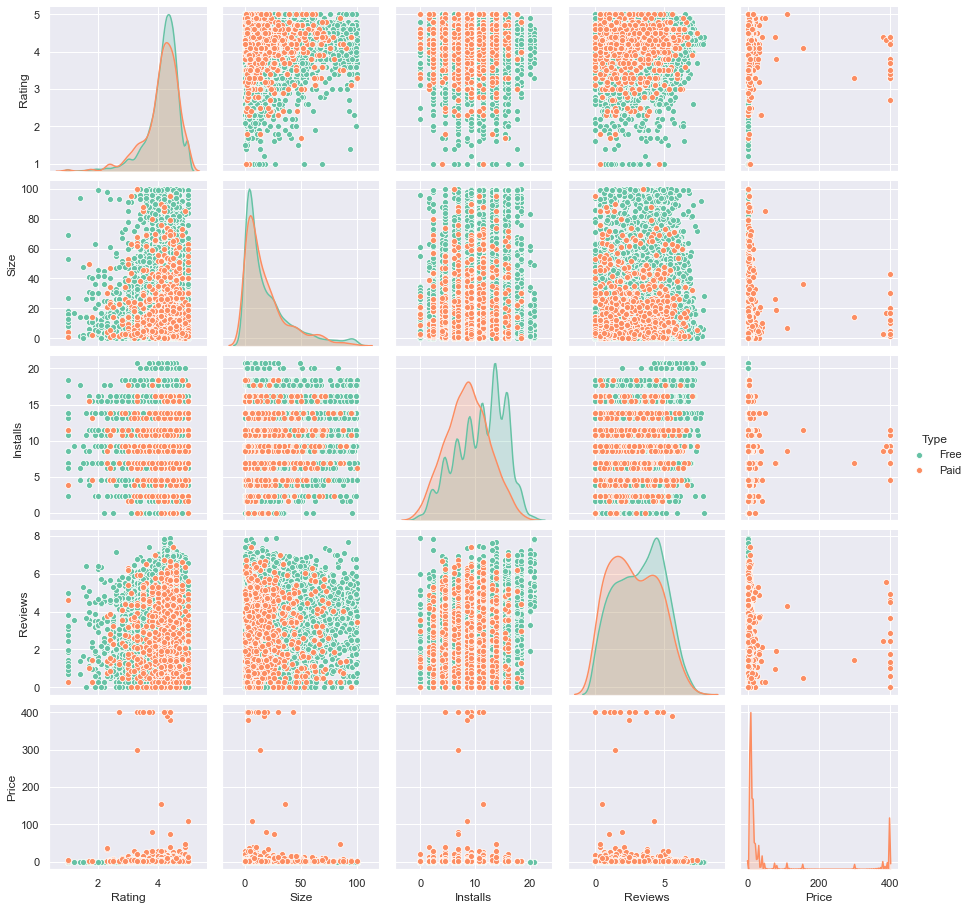

In [25]:
x = df['Rating'].dropna()
y = df['Size'].dropna()
z = df['Installs'][df.Installs!=0].dropna()
p = df['Reviews'][df.Reviews!=0].dropna()
t = df['Type'].dropna()
price = df['Price']

p = sns.pairplot(pd.DataFrame(list(zip(x, y, np.log(z), np.log10(p), t, price)), 
                        columns=['Rating','Size', 'Installs', 'Reviews', 'Type', 'Price']), hue='Type', palette="Set2")

The heatmap represents the correlation of all of important attributes based on the type of the application. It is a general comparison of attributes for free and paid applications. 
All of the figures given above represent the gradual change in values of attributes in the dataset in accordance to the number of applications.


## Frequency dist and histograms of attributes

In [26]:
#distribution of apps by category
number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

#### Frequency Distribution of categories of apps in the playstore

In [27]:
#dis
df['Category'].value_counts().iplot(kind='bar', title='Frequency', xTitle='Category', yTitle = 'number of app')

#### Number of Applications per category

In [28]:
#distribution of apps by content rating
number_of_apps = df['Content Rating'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps.index,
        values = number_of_apps.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='content rating')

#### Frequency Distribution of Content Ratings across all apps in the playstore

In [29]:
df['Content Rating'].value_counts().iplot(kind='bar', title='Frequency', xTitle='Rating', yTitle = 'number of app')

#### Number of Applications by Content Rating

In [30]:
#distribution of ratings
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print('Average app rating = ', np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

Average app rating =  4.173243045387998


#### Frequency Distribution of Ratings across all applications

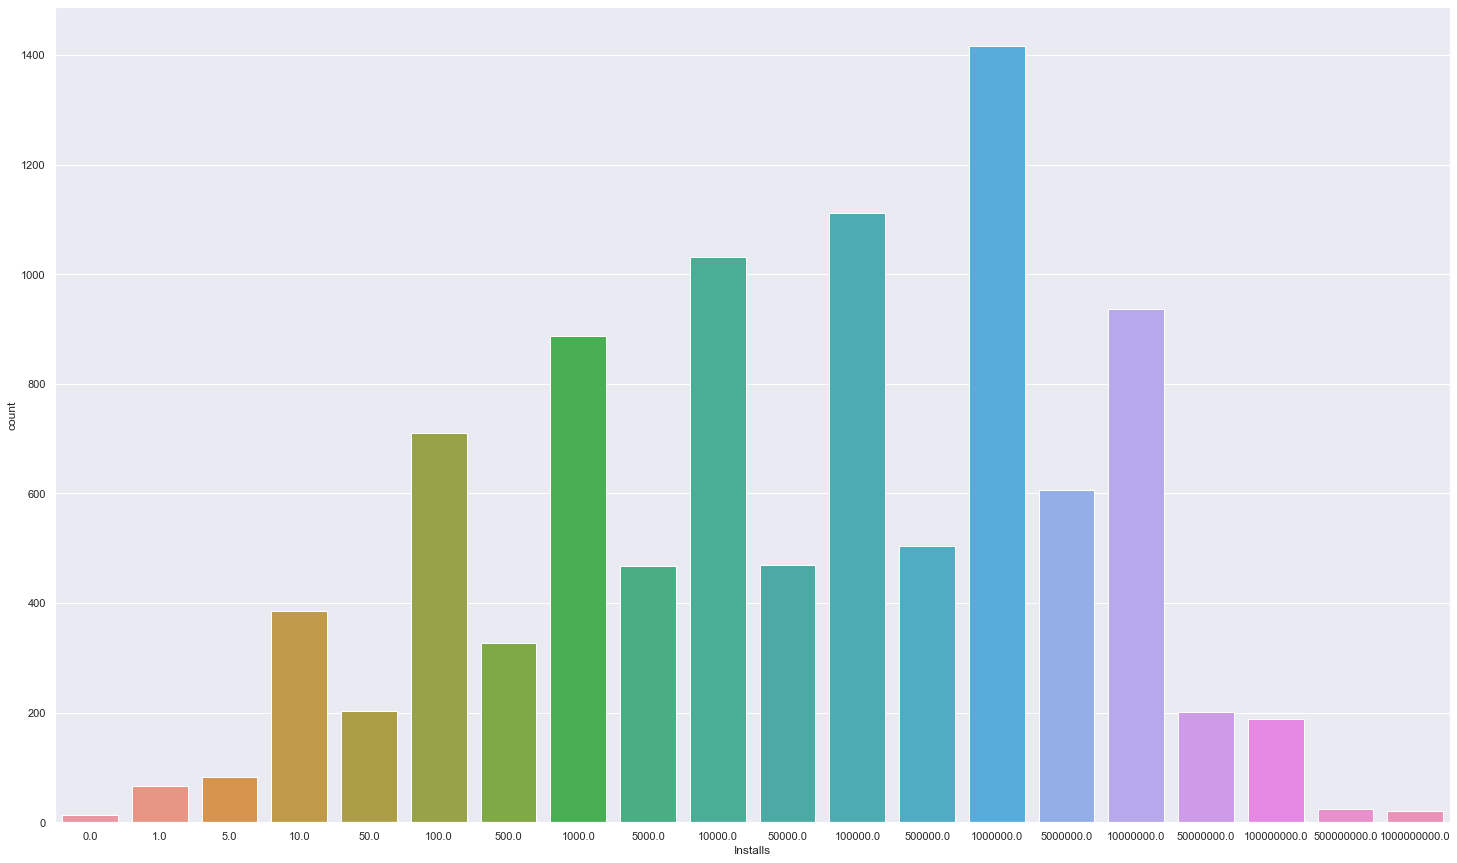

In [31]:
#Distribution of Installs
sns.countplot('Installs', data=df)

#### This graph denotes the distribution of apps accroding to their number of downloads/installs.

## Sizing Strategy

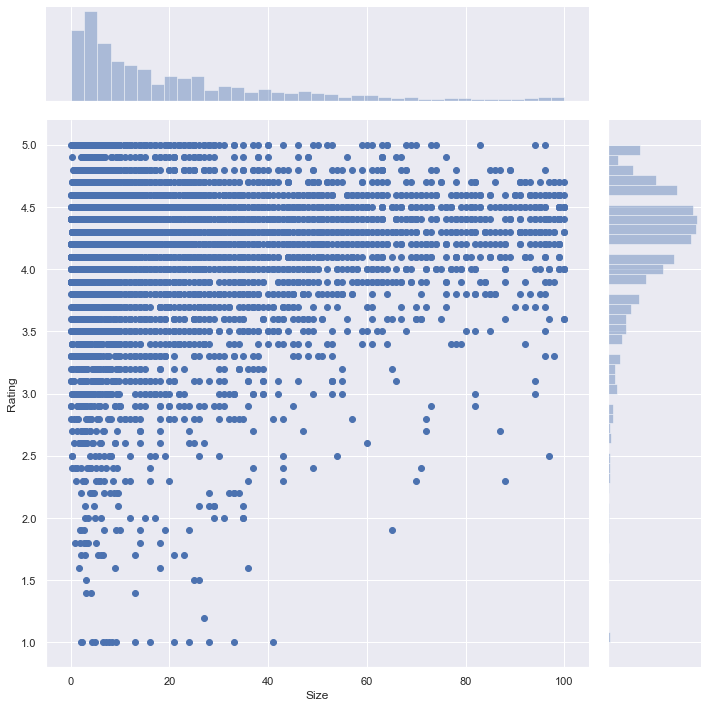

In [32]:
#Ratings by size
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size'], df['Rating'], height = 10)


#### Most top rated apps are optimally sized between ~2MB to ~40MB - neither too light nor too heavy.

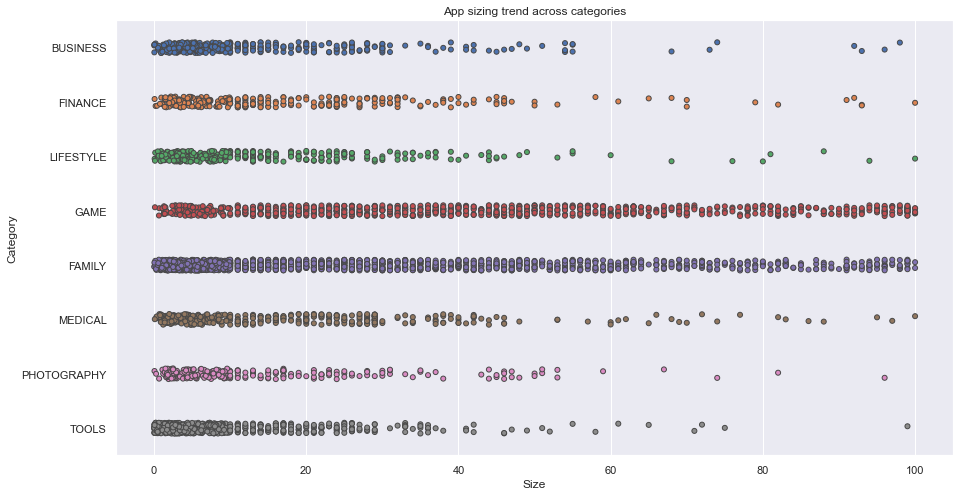

In [33]:
#Size distribution by category
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.stripplot(x="Size", y="Category", data=subset_df, linewidth=1)
title = ax.set_title('App sizing trend across categories')

#### This graph show the size trend accross the category. We can infer that most apps are sized below 30mb.

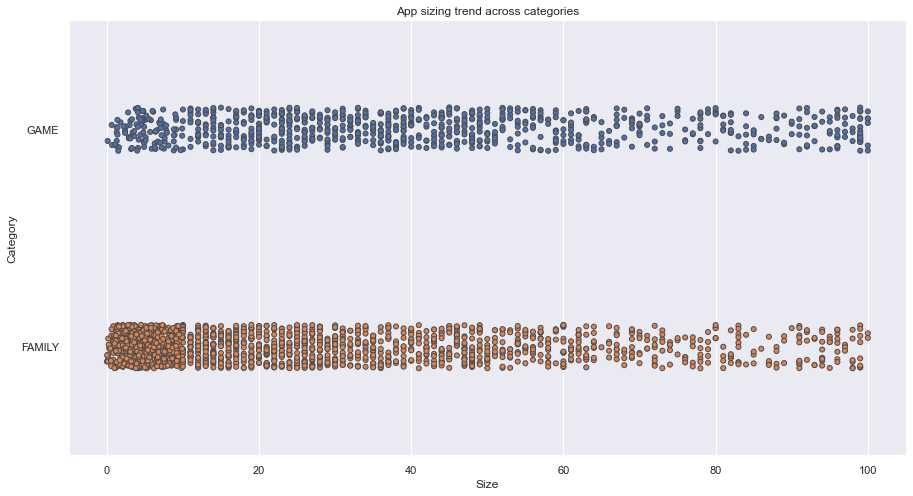

In [34]:
#Size distribution by category
subset_df = df[df.Category.isin(['GAME', 'FAMILY'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.stripplot(x="Size", y="Category", data=subset_df, linewidth=1)
title = ax.set_title('App sizing trend across categories')

#### This graphs show the size trend in the 2 most popular category. We can see that many apps in these 2 categories are sized well above 20mb which hints that these 2 categories are bulky on purpose. We'll check the impact of this on the ratings in the next graph.

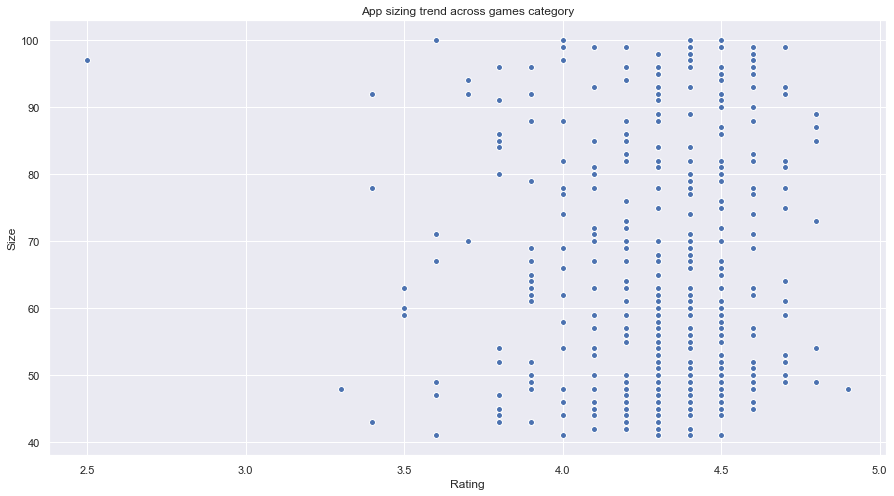

In [35]:
#Sizing of games 
subset_df = df[df.Size>40]
subset_df = subset_df[df.Category.isin(['GAME'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.scatterplot(x="Rating", y="Size",data=subset_df, linewidth=1)
p.set()
title = ax.set_title('App sizing trend across games category')

#### App sizing trends for the games category we can observe that games tend to be a heavy size category on purpose. The ratings are not affected even if the size of the app is more that average.

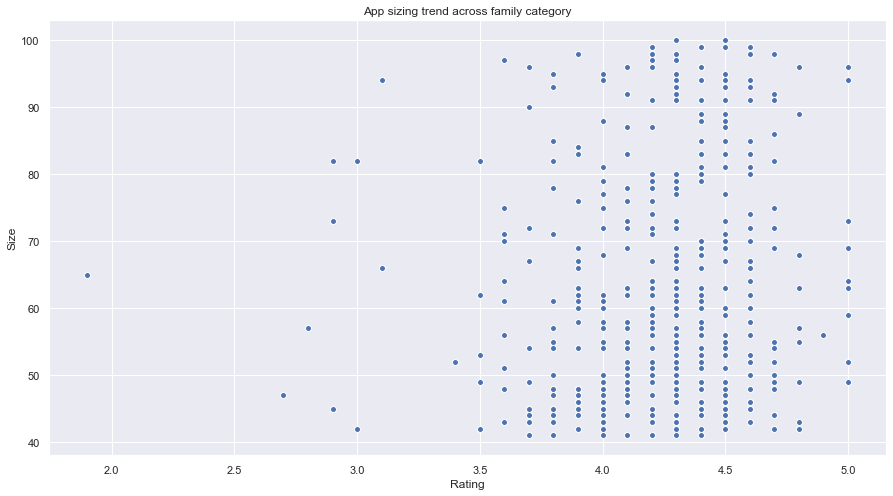

In [36]:
#Sizing of Family 
subset_df = df[df.Size>40]
subset_df = subset_df[df.Category.isin(['FAMILY'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.scatterplot(x="Rating", y="Size",data=subset_df, linewidth=1)
p.set()
title = ax.set_title('App sizing trend across family category')

#### App sizing trends for the games category we can observe that games tend to be a heavy size category on purpose. The ratings are not affected even if the size of the app is more that average.

In [37]:
subset_df = df[df.Size>40]
subset_df = subset_df[df.Category.isin(['GAME','FAMILY'])]

data = [{
    'x': subset_df.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    } for category in enumerate(['GAME', 'FAMILY'])]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'black'}

plotly.offline.iplot({'data': data, 'layout': layout})



#### Most bulky apps ( >50MB) belong to the Game and Family category. Despite this, these bulky apps are fairly highly rated indicating that they are bulky for a purpose.

## Pricing Strategy

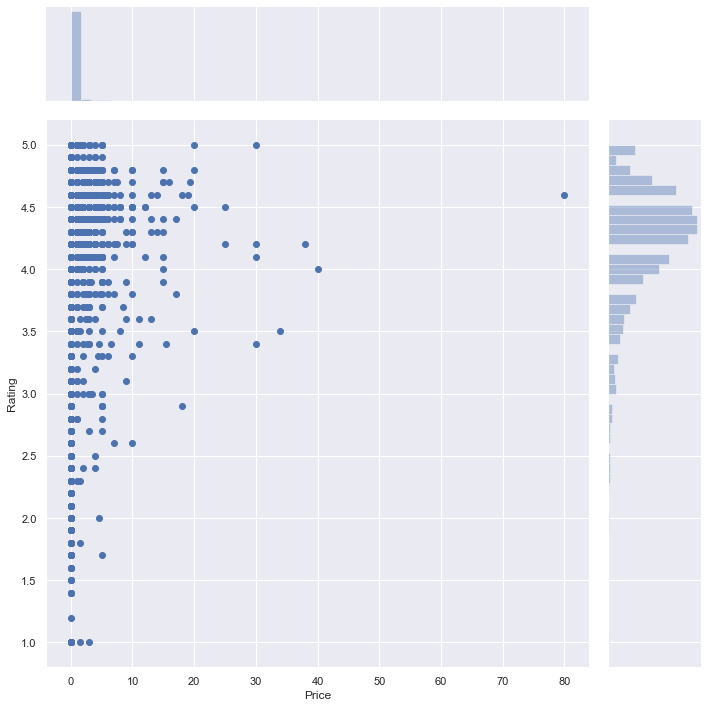

In [38]:
paid_apps = df[df.Price<100]
p = sns.jointplot( "Price", "Rating", paid_apps, height=10)

#### Most top rated apps are optimally priced between 1 - 20 dollars. There are only a very few apps priced above 20 dollars.

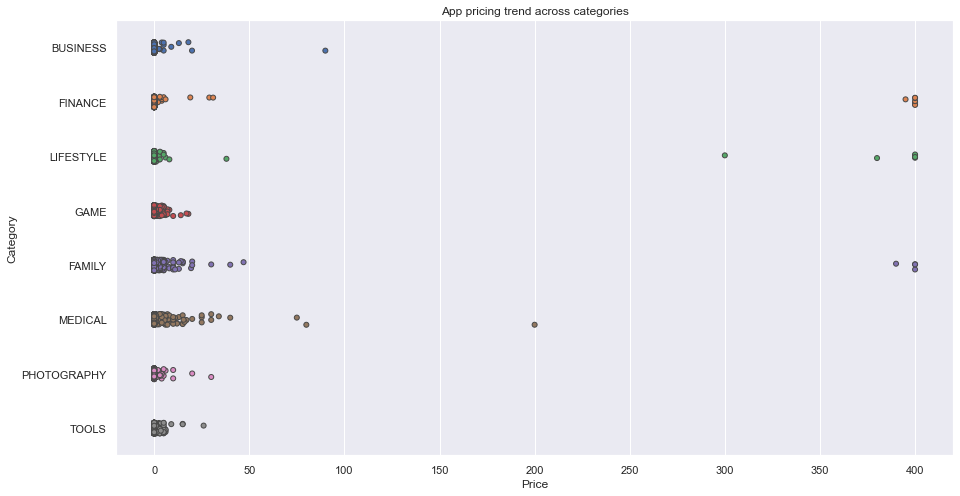

In [39]:
#Pricing across category
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.stripplot(x="Price", y="Category", data=subset_df, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories')

#### Above graph shows the distribution of pricing according to the categories of applications.

#### We can observe some applications that are priced over 200 dollars. Here, we take a look at them.

In [40]:
#print('Junk apps priced above 200$')
df[['Category', 'App']][df.Price > 200]

,Category,App
4197,FAMILY,most expensive app (H)
4362,LIFESTYLE,💎 I'm rich
4367,LIFESTYLE,I'm Rich - Trump Edition
5351,LIFESTYLE,I am rich
5354,FAMILY,I am Rich Plus
5355,LIFESTYLE,I am rich VIP
5356,FINANCE,I Am Rich Premium
5357,LIFESTYLE,I am extremely Rich
5358,FINANCE,I am Rich!
5359,FINANCE,I am rich(premium)


#### These apps are non functional status quo type of apps. These apps create an unwanted bias in the model, therefore we filter them out. 

In [41]:
df = df.drop(df.index[temp])

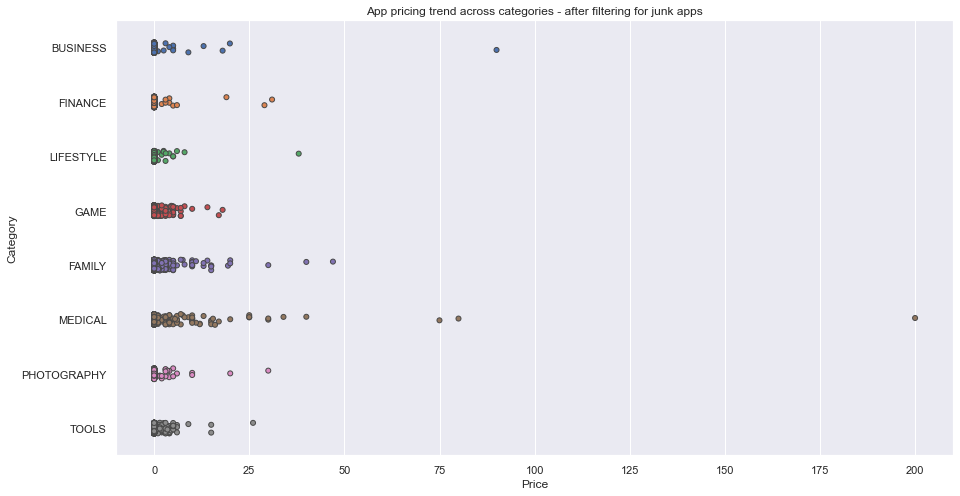

In [42]:
#Pricing after filtering the junk apps
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
subset_df_price = subset_df[subset_df.Price<250]
p = sns.stripplot(x="Price", y="Category", data=subset_df_price, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories - after filtering for junk apps')

#### It is evident that Medical and Family apps are the most expensive across the playstore.

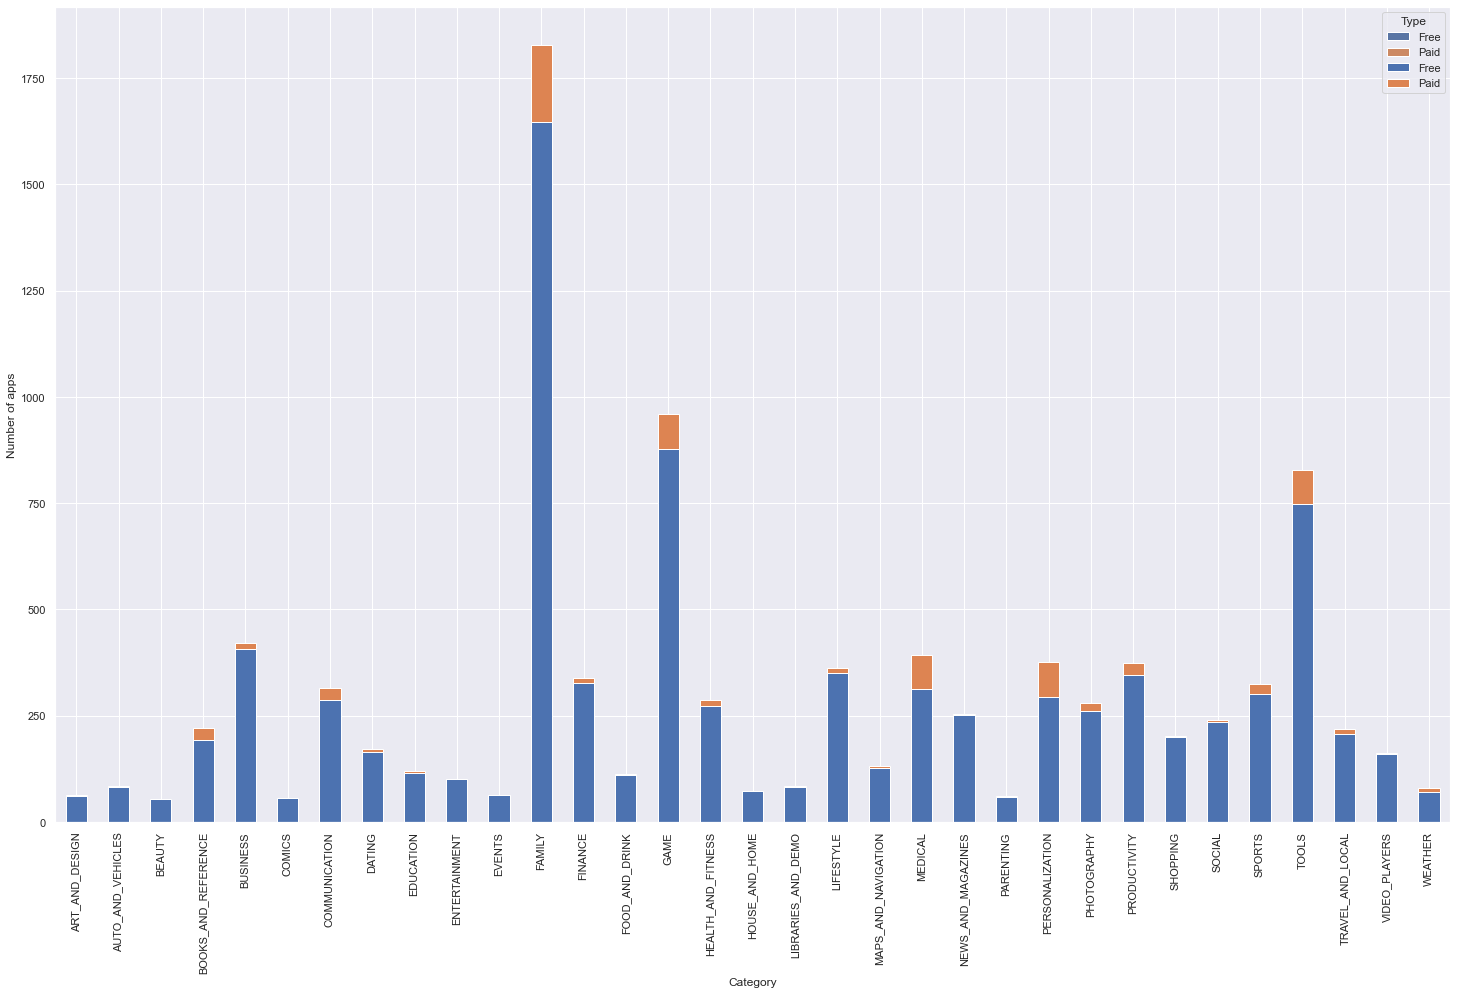

In [43]:

new_df = df.groupby(['Category', 'Type']).agg({'App' : 'count'}).reset_index()
ax = sns.countplot(x="Category", hue="Type", data=new_df)

df.groupby(['Category', 'Type']).count()['App'].unstack().plot(kind='bar', stacked=True, ax=ax)
ylabel = plt.ylabel('Number of apps')

#### This is the graph of category wise frequency distribution for paid vs free apps. We can see that Family, Games and Medical category have most paid apps. 

## Paid Apps downloads

In [44]:
#Number of installs for free vs paid apps
trace0 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Number of downloads of paid apps Vs free apps",
    yaxis= {'title': 'Number of downloads (log-scaled)'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

### Logarithmic box chart comparing the number of installs of the free and paid apps. Here we can observe that even though free apps are more readily available they aren't downloaded all that much since the gap between the number of downloads isn't huge. This also tells that all the paid apps are very useful or in some cases very essential services.

## Paid apps vs free apps downloads

In [45]:
#Number of installs for free vs paid apps
trace0 = go.Box(
    y=(df['Rating'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=(df['Rating'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Ratings of paid apps Vs free apps",
    yaxis= {'title': 'Ratings'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

### We can observe that the both categories are pretty much equal when it comes to the rating which suggests there isnt much difference of quality in these applications.  Although we can  note that the low for free apps is lower in comparison to the paid apps which suggests that people are generally harsher while rating a free app compared to when rating a paid app.

## Paid Apps Sizing

In [46]:
#Ratings vs Size of Paid Apps
temp_df = df[df.Type == 'Paid']
temp_df = temp_df[temp_df.Size > 5]
#type_groups = df.groupby('Type')

data = [{
    #'x': type_groups.get_group(t)['Rating'], 
    'x' : temp_df['Rating'],
    'type':'scatter',
    'y' : temp_df['Size'],
    #'name' : t,
    'mode' : 'markers',
    #'showlegend': True,
    'text' : df['Size'],
    } for t in set(temp_df.Type)]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

### Graph shows the relation between the ratings and the size of Paid applications. We can observe that it is very much similar to the relation observed for Free Apps.

## Effect of Reviews

Text(0.5, 1.0, 'Rating VS Reveiws')

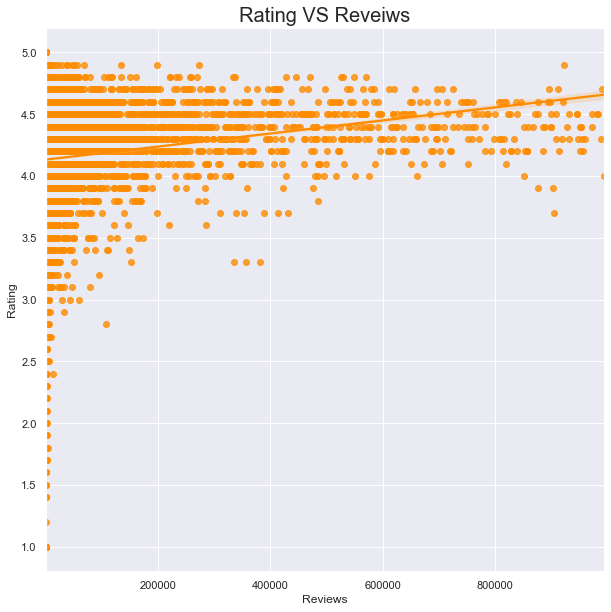

In [48]:
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", color = 'darkorange',data=df[df['Reviews']<1000000]);
plt.title('Rating VS Reveiws',size = 20)

### This is the scatterplot of rating vs review. We can observe that having a high number of reviews generally results in having a higher rating for the application.

========================================================================================================

# NLP

In [49]:
reviews=pd.read_csv("googleplaystore_user_reviews.csv")

### The Reviews Dataset

In [50]:
reviews.head(10)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000
6,10 Best Foods for You,Amazing,Positive,0.60,0.900000
7,10 Best Foods for You,NaN,NaN,NaN,NaN
8,10 Best Foods for You,"Looking forward app,",Neutral,0.00,0.000000
9,10 Best Foods for You,It helpful site ! It help foods get !,Neutral,0.00,0.000000


In [51]:
data=pd.concat([reviews.Translated_Review,reviews.Sentiment],axis=1)
data.dropna(axis=0,inplace=True)
data.head(10)

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive
6,Amazing,Positive
8,"Looking forward app,",Neutral
9,It helpful site ! It help foods get !,Neutral
10,good you.,Positive
11,Useful information The amount spelling errors ...,Positive


#### We convert the setiment to numeric values i.e Positive=0, negative=1, neutral=2

In [52]:
data.Sentiment=[0 if i=="Positive" else 1 if i== "Negative" else 2 for i in data.Sentiment]
data.head(10)

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,0
1,This help eating healthy exercise regular basis,0
3,Works great especially going grocery store,0
4,Best idea us,0
5,Best way,0
6,Amazing,0
8,"Looking forward app,",2
9,It helpful site ! It help foods get !,2
10,good you.,0
11,Useful information The amount spelling errors ...,0


#### Here we will remove characters which are not letters. ":) # $ @ ()!-/*" like that!

#### Also converting them lower case.

In [53]:
#Data cleaning
import re
first_text=data.Translated_Review[0]
text=re.sub("[^a-zA-Z]"," ",first_text) #changing characters with space
text=text.lower()

#### Example of the operation.

In [54]:
text

'i like eat delicious food  that s i m cooking food myself  case     best foods  helps lot  also  best before  shelf life  '

#### We import the nltk package (natural language processing toolkit) and perform various operations on the data.

In [55]:
import nltk
#nltk.download("stopwords")
#nltk.download("punkt")
from nltk.corpus import stopwords
text=nltk.word_tokenize(text) #separate all words

#### The first operation we perform is tokenization where we seperate all the words and create a list with words as elements.

In [56]:
text

['i',
 'like',
 'eat',
 'delicious',
 'food',
 'that',
 's',
 'i',
 'm',
 'cooking',
 'food',
 'myself',
 'case',
 'best',
 'foods',
 'helps',
 'lot',
 'also',
 'best',
 'before',
 'shelf',
 'life']

#### Lemmetization transforms words into their root form

In [57]:
#lemmatization books----> book
import nltk as nlp
#nltk.download('wordnet')
lemma=nlp.WordNetLemmatizer()
text=[lemma.lemmatize(i) for i in text]
text=" ".join(text)
text

'i like eat delicious food that s i m cooking food myself case best food help lot also best before shelf life'

In [58]:
text_list=[]
for i in data.Translated_Review:
    text=re.sub("[^a-zA-Z]"," ",i)
    text=text.lower()
    text=nltk.word_tokenize(text)
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    text=" ".join(text)
    text_list.append(text)

### The dataset is then converted into a list with each review as an element.

In [59]:
text_list[:2]

['i like eat delicious food that s i m cooking food myself case best food help lot also best before shelf life',
 'this help eating healthy exercise regular basis']

In [60]:
merged_df = df.join(data,  how = "inner")
merged_df = merged_df.dropna(subset=['Sentiment', 'Translated_Review'])

In [61]:
merged_df['Sentiment_Polarity'] = reviews['Sentiment_Polarity']

In [62]:
merged_df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Translated_Review,Sentiment,Sentiment_Polarity
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,I like eat delicious food. That's I'm cooking ...,0,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,This help eating healthy exercise regular basis,0,0.250000
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,Works great especially going grocery store,0,0.400000
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,Best idea us,0,1.000000
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6,50000.0,Free,0.0,Everyone,Art & Design,Best way,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10835,FR Forms,BUSINESS,NaN,0,9.6,10.0,Free,0.0,Everyone,Business,Its nice u make realistic like movie make free...,0,0.291667
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,5000.0,Free,0.0,Everyone,Education,I love scan qr code change special attack valt...,0,0.531429
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5,1000.0,Free,0.0,Everyone,Medical,It amazing game I loved I updated stared telli...,0,0.100000
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,NaN,1000.0,Free,0.0,Mature 17+,Books & Reference,You able control beyblades movement like joyst...,0,0.050000


In [63]:
from wordcloud import WordCloud

### We create a wordcloud of the most frequently used in the reviews

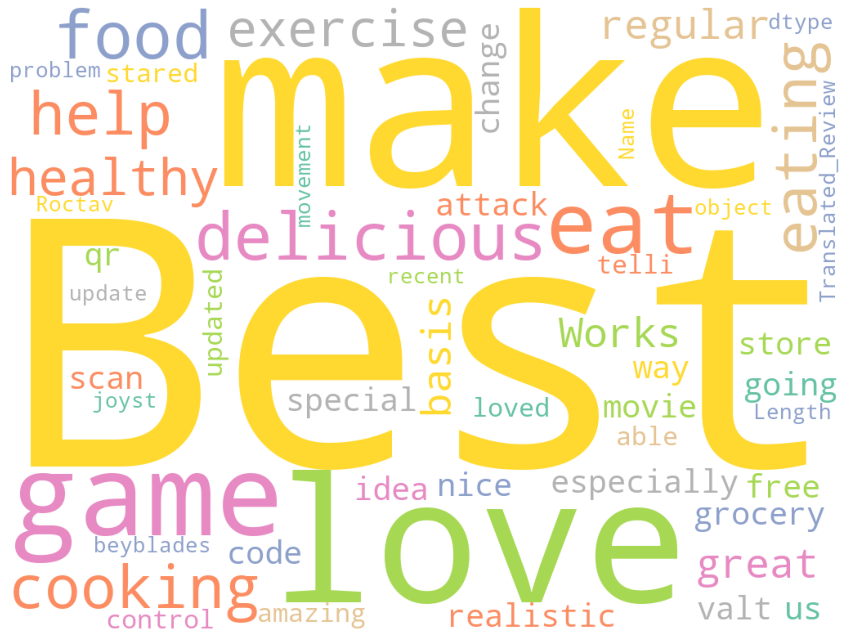

In [64]:
free = merged_df.loc[merged_df.Type=='Free']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wordcloud=WordCloud(background_color="white",width=1024,height=768,max_words=200, colormap="Set2").generate(''.join(str(free)))
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### For Free applications
### Positive words: Best, Love, Nice

### Negative words: Problem, AD, 

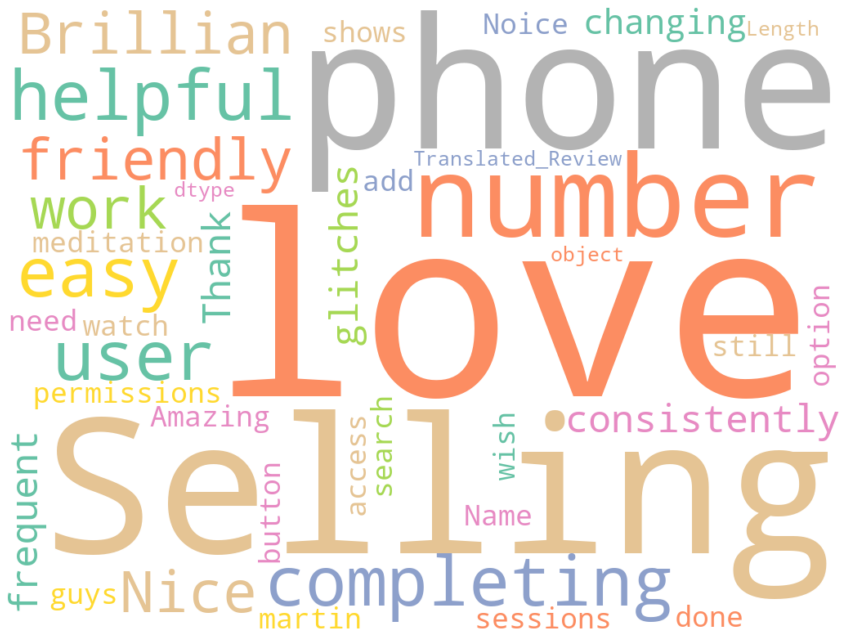

In [65]:
paid = merged_df.loc[merged_df.Type=='Paid']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wordcloud=WordCloud(background_color="white",width=1024,height=768, colormap="Set2").generate(''.join(str(paid)))
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### For Paid applications
### Positive Words: helpful, nice, amazing

### Negative Words: glitches, ad

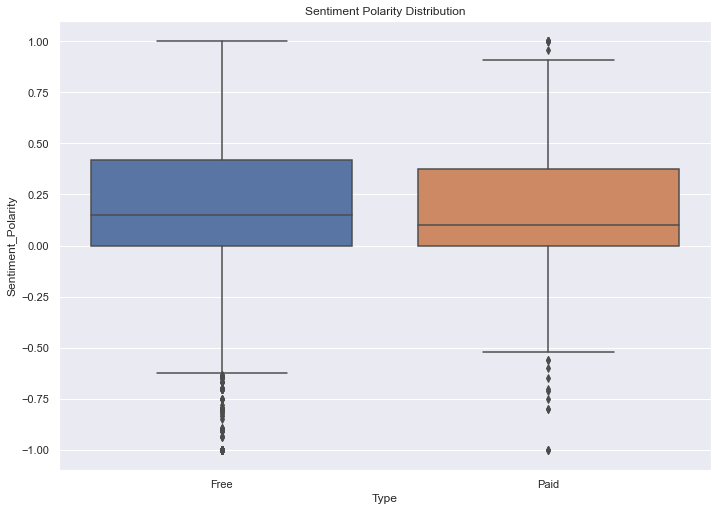

In [66]:
sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
title = ax.set_title('Sentiment Polarity Distribution')

### Free apps receive a lot of harsh comments which are indicated as outliers on the negative Y-axis.

### Users are more lenient and tolerant while reviewing paid apps - moderate choice of words. They are never extremely negative while reviewing a paid app.

## Confusion Matrices

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=50000
cou_vec=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=cou_vec.fit_transform(text_list).toarray()
all_words=cou_vec.get_feature_names()

aw = pd.Series(all_words)
aw.count()
#print("Most used words: ",all_words)

17404

### We use Logistic Regresssion and Random Forest methods to classify the reviews according to sentiments.

## Random Forest Method

In [68]:
y=data.iloc[:,1].values
x=sparce_matrix
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

### Accuracy of the model

In [69]:
#Random Forest
#holdout method/ k-fold method
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(x_train,y_train)
print("Accuracy of the model: ",rf.score(x_test,y_test))

Accuracy of the model:  0.877504675394069


### Confusion matrix for error calculation

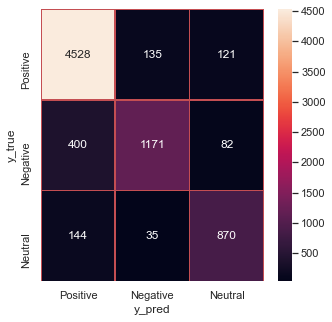

In [70]:
#confussion matrix
y_pred=rf.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Confusion matrix for random forest classifier. It is evident that the majority of the reviews were accurately predicted, there are a total of 400 False Positives and 135 False Negatives with a total of 6569 accurate predictions. The Random Forest Classifier scores an accuracy score of 87.71%. 

## Logistic Regression method

### Accuracy of the model

In [71]:
#logistic Regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
print("Accuracy of the model: ",lr.score(x_test,y_test))

Accuracy of the model:  0.9086294416243654


### Confusion Matrix for error calculation

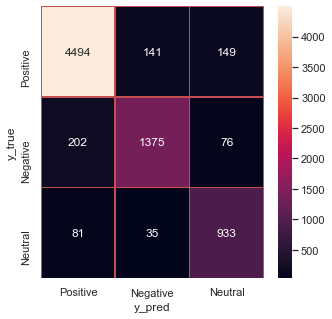

In [72]:
#confussion matrix
y_pred=lr.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Confusion matrix for logistic regression. It is observed that the Logistic regression model used as a classifier performs better than the random forest classifier on the given data set. 
### A total of 6802 entries were predicted accurately with 202 false positives and 141 false negatives. Logistic Model produces an accuracy of 90.8% on the user reviews dataset. 

=============================================================================================

# PREDICTION OF RATINGS

### For Prediction of ratings we use 3 methods,
1. Linear Regression
2. Support Vector Machine
3. Random Forest Regression

In [24]:
df1 = pd.read_csv("google.csv",squeeze = True)
print(len(df))
df1.dropna(inplace = True)

9658


In [25]:
#dropping of unrelated and unnecessary items
df1.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

#Converting Type classification into binary
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

df1['Type'] = df1['Type'].map(type_cat)

#Cleaning of content rating classification
RatingL = df1['Content Rating'].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
df1['Content Rating'] = df1['Content Rating'].map(RatingDict).astype(int)

#Cleaning of genres
GenresL = df1.Genres.unique()
GenresDict = {}
for i in range(len(GenresL)):
    GenresDict[GenresL[i]] = i
df1['Genres_c'] = df1['Genres'].map(GenresDict).astype(int)

# Cleaning Categories into integers
CategoryString = df1["Category"]
categoryVal = df1["Category"].unique()
categoryValCount = len(categoryVal)
category_dict = {}
for i in range(0,categoryValCount):
    category_dict[categoryVal[i]] = i
df1["Category_c"] = df1["Category"].map(category_dict).astype(int)

# convert reviews to numeric
df1['Reviews'] = df1['Reviews'].astype(int)

#scaling and cleaning size of installation
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df1["Size"] = df1["Size"].map(change_size)

#filling Size which had NA
df1.Size.fillna(method = 'ffill', inplace = True)

df1.Installs=df1.Installs.apply(lambda x: x.strip('+'))
df1.Installs=df1.Installs.apply(lambda x: x.replace(',',''))
df1.Installs=df1.Installs.replace('Free',np.nan)

df1.Price=df1.Price.apply(lambda x: x.strip('$'))

In [26]:
#for evaluation of error term and 
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

In [27]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = ''):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

# Linear Regression

In [28]:
#Linear model for ratings
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
X = df1.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = df1.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)
pred = pd.Series(Results)
#pred.sort_values()

resultsdf = pd.DataFrame()
resultsdf = resultsdf.from_dict(Evaluationmatrix_dict(y_test,Results,name = 'Linear Model'),orient = 'Index')
resultsdf = resultsdf.transpose()

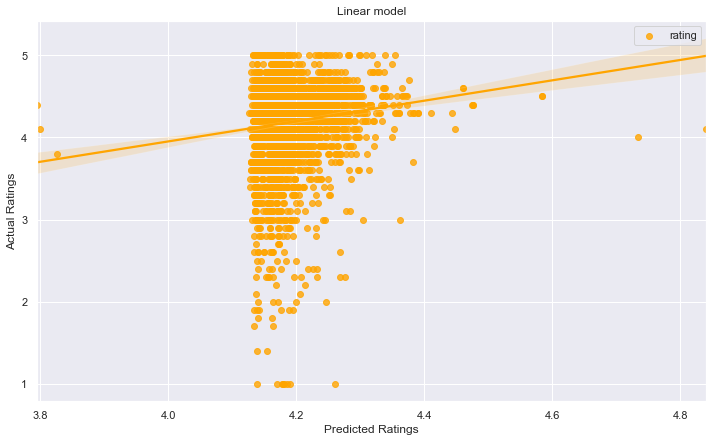

In [29]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='orange',label = 'rating')
plt.legend()
plt.title('Linear model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Result

In [30]:
print ('Mean Ratings: ' + str(Results.mean()))

Mean Ratings: 4.191696373059148


In [44]:
df1

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Genres_c,Category_c
0,ART_AND_DESIGN,4.1,159,19000000.0,10000,0,0,0,Art & Design,0,0
1,ART_AND_DESIGN,3.9,967,14000000.0,500000,0,0,0,Art & Design;Pretend Play,1,0
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000,0,0,0,Art & Design,0,0
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,0,0,1,Art & Design,0,0
4,ART_AND_DESIGN,4.3,967,2800000.0,100000,0,0,0,Art & Design;Creativity,2,0
...,...,...,...,...,...,...,...,...,...,...,...
10834,FAMILY,4.0,7,2600000.0,500,0,0,0,Education,12,18
10836,FAMILY,4.5,38,53000000.0,5000,0,0,0,Education,12,18
10837,FAMILY,5.0,4,3600000.0,100,0,0,0,Education,12,18
10839,BOOKS_AND_REFERENCE,4.5,114,3600000.0,1000,0,0,3,Books & Reference,5,3


In [47]:
data = [87510, 87000000, 5000000,0,0,0,0,0]
data = np.reshape(data, (1, -1))
model.predict(data)

array([4.29636529])

### Error calculation

In [31]:
print('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,Results)))
print('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,Results)))
print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_test,Results)))

Mean Squared Error: 0.2695106655031112
Mean absolute Error: 0.360957636885425
Mean squared Log Error: 0.013493088376461206


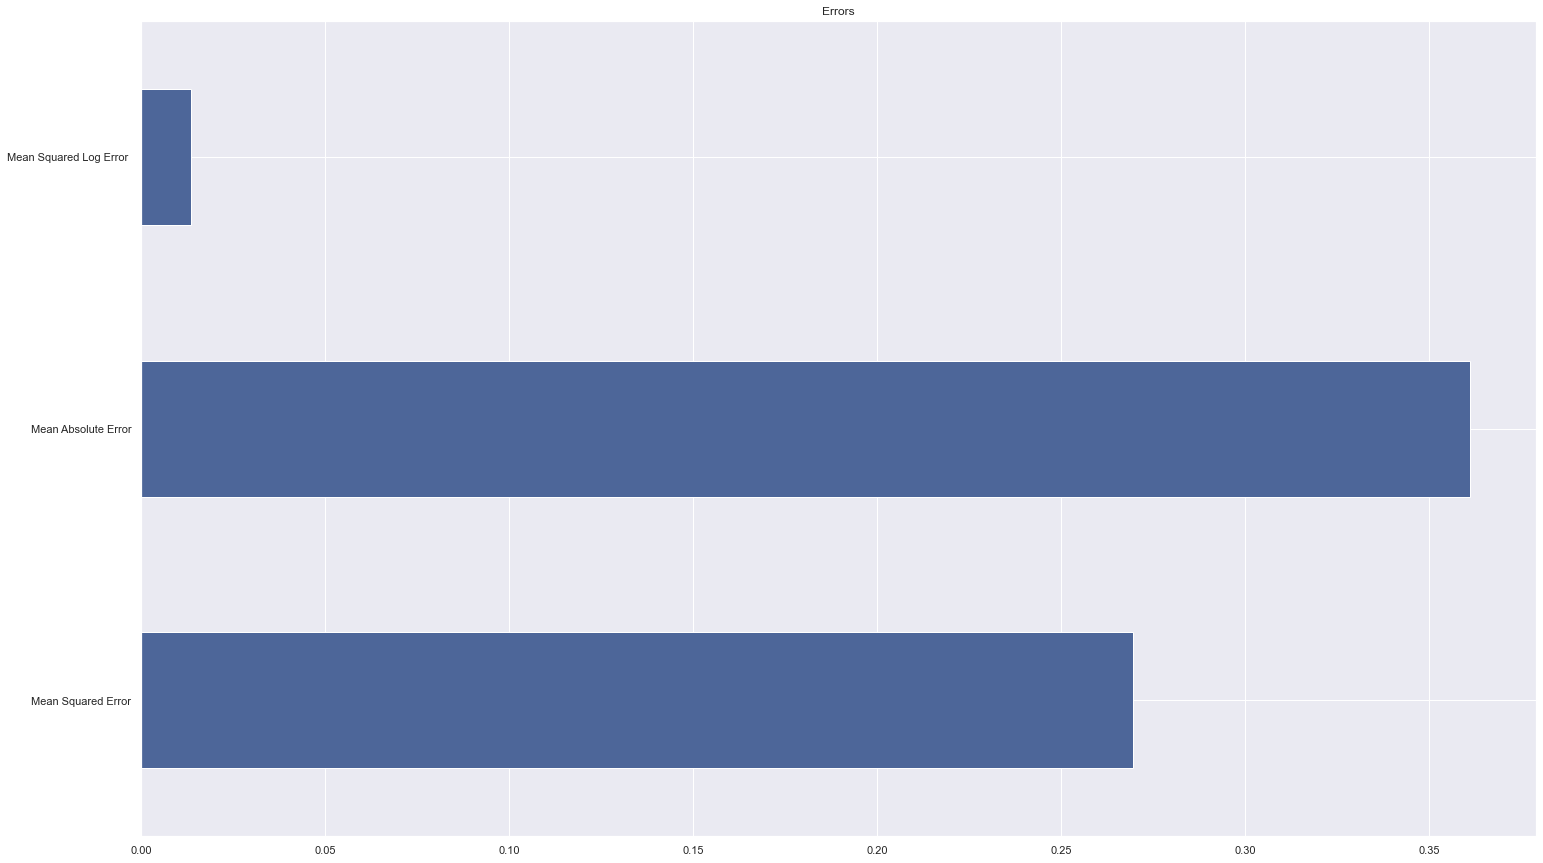

In [32]:
dict1 = {"Mean Squared Error":metrics.mean_squared_error(y_test,Results),"Mean Absolute Error" : metrics.mean_absolute_error(y_test,Results),
        "Mean Squared Log Error ": metrics.mean_squared_log_error(y_test,Results)}

lr = pd.Series(dict1)
lr.plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Errors')

In [33]:
resultsdf

,Series Name,Mean Squared Error,Mean Absolute Error,Mean Squared Log Error
0,Linear Model,0.269511,0.360958,0.0134931


# SVM

In [34]:
from sklearn import svm
model2 = svm.SVR()

X = df1.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = df1.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model2.fit(X_train,y_train)

Results2 = model2.predict(X_test)
pred2 = pd.Series(Results2)
pred2.sort_values()

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results2, name = 'SVM model'),ignore_index = True)

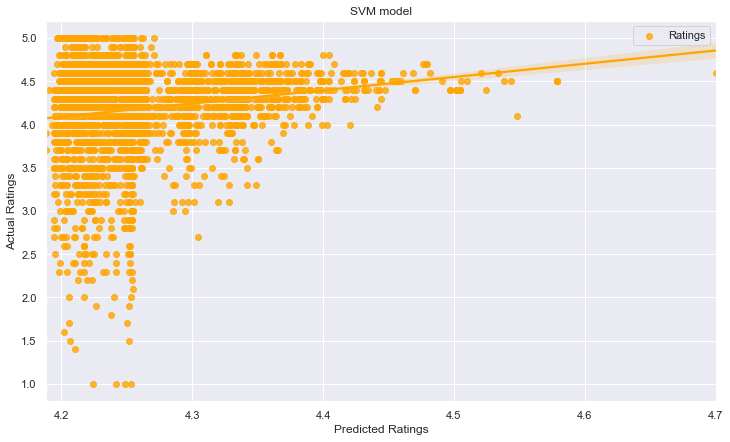

In [35]:
plt.figure(figsize=(12,7))
sns.regplot(Results2,y_test,color='orange', label = 'Ratings')
plt.legend()
plt.title('SVM model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Results

In [36]:
print ('Mean Ratings: ' + str(Results2.mean()))

Mean Ratings: 4.266935535619368


### Error Calculation

In [37]:
print('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,Results2)))
print('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,Results2)))
print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_test,Results2)))

Mean Squared Error: 0.27136978462255446
Mean absolute Error: 0.35322412485615345
Mean squared Log Error: 0.013224577320301576


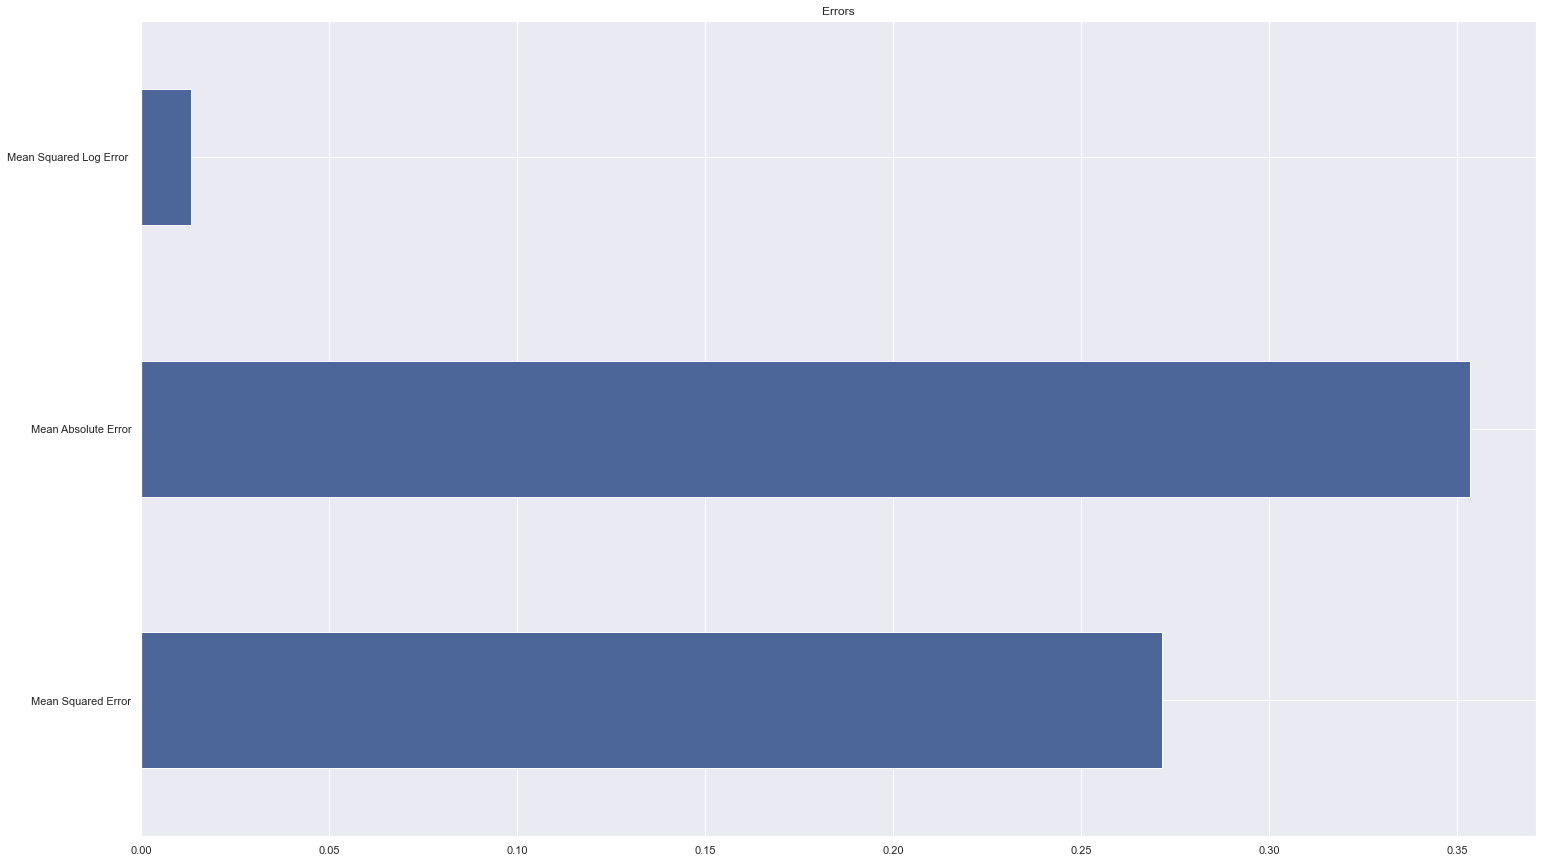

In [38]:
dict2 = {"Mean Squared Error":metrics.mean_squared_error(y_test,Results2),"Mean Absolute Error" : metrics.mean_absolute_error(y_test,Results2),
        "Mean Squared Log Error ": metrics.mean_squared_log_error(y_test,Results2)}

svm = pd.Series(dict2)
svm.plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Errors')

In [39]:
resultsdf

,Series Name,Mean Squared Error,Mean Absolute Error,Mean Squared Log Error
0,Linear Model,0.269511,0.360958,0.0134931
1,SVM model,0.27137,0.353224,0.0132246


# Random Forest Regression

In [40]:
#random forest model for ratings
from sklearn.ensemble import RandomForestRegressor

X = df1.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = df1.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model3 = RandomForestRegressor()
model3.fit(X_train,y_train)
Results3 = model3.predict(X_test)
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results3, name = 'RFR Model'),ignore_index = True)

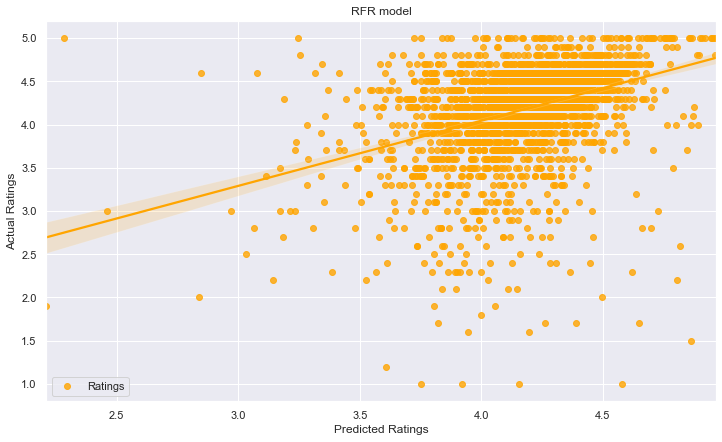

In [41]:
plt.figure(figsize=(12,7))
sns.regplot(Results3,y_test,color='orange', label = 'Ratings')

plt.legend()
plt.title('RFR model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Result

In [42]:
print ('Mean Ratings:' + str(Results3.mean()))

Mean Ratings:4.188271860161444


### Error Calculation

In [126]:
print('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,Results3)))
print('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,Results3)))
print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_test,Results3)))

Mean Squared Error: 0.21834426359666823
Mean absolute Error: 0.30736083808167136
Mean squared Log Error: 0.010850579019678808


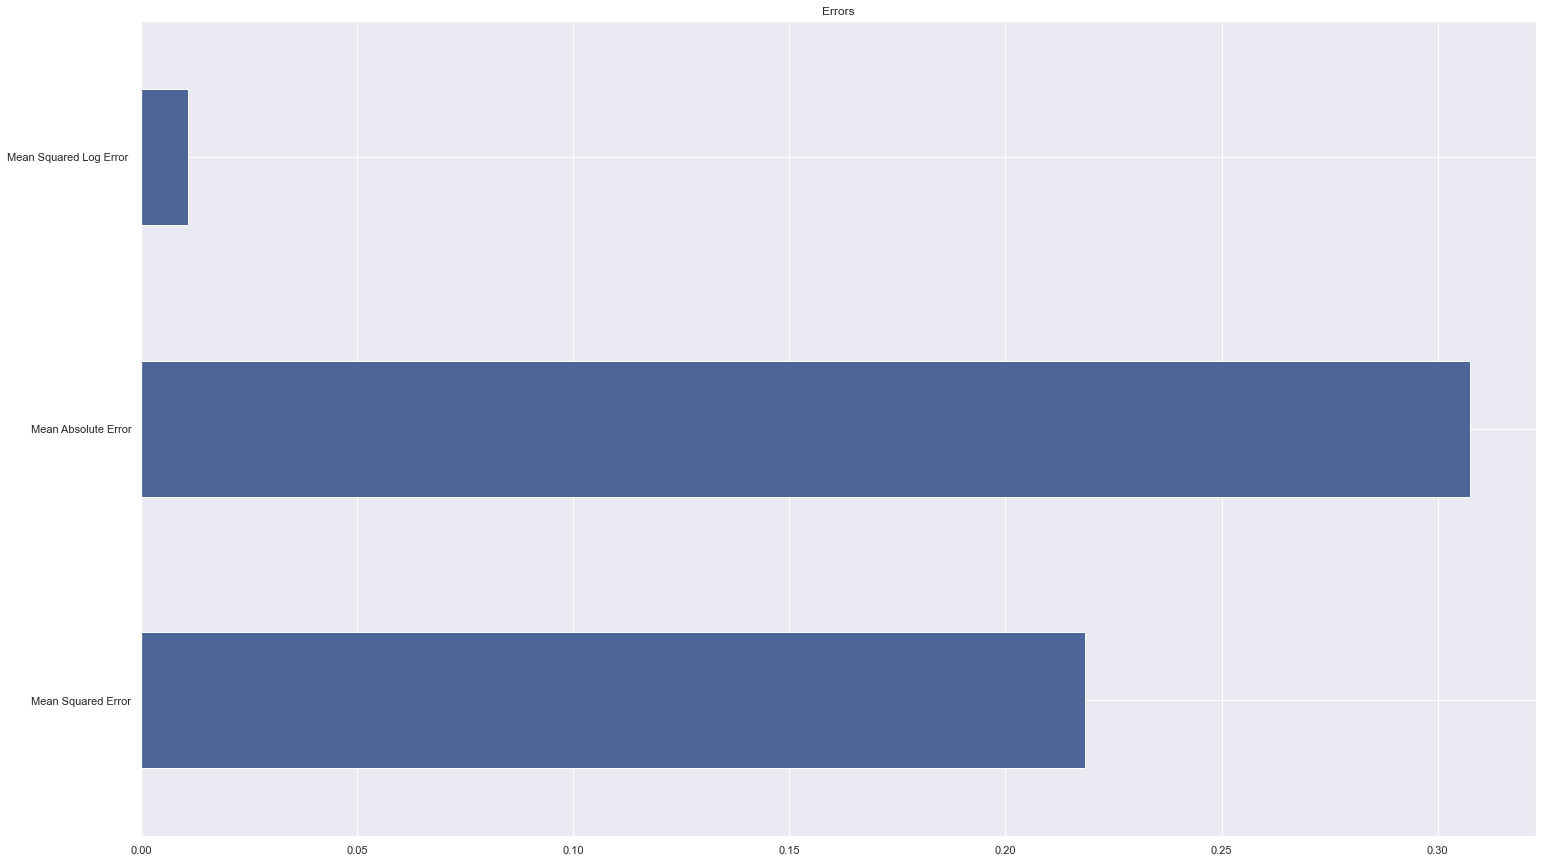

In [127]:
dict3 = {"Mean Squared Error":metrics.mean_squared_error(y_test,Results3),"Mean Absolute Error" : metrics.mean_absolute_error(y_test,Results3),
        "Mean Squared Log Error ": metrics.mean_squared_log_error(y_test,Results3)}

rfr = pd.Series(dict3)
rfr.plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Errors')

In [128]:
resultsdf

,Series Name,Mean Squared Error,Mean Absolute Error,Mean Squared Log Error
0,Linear Model,0.269894,0.366606,0.0131295
1,SVM model,0.249417,0.336968,0.0121747
2,RFR Model,0.218344,0.307361,0.0108506


## Error Calculation Results

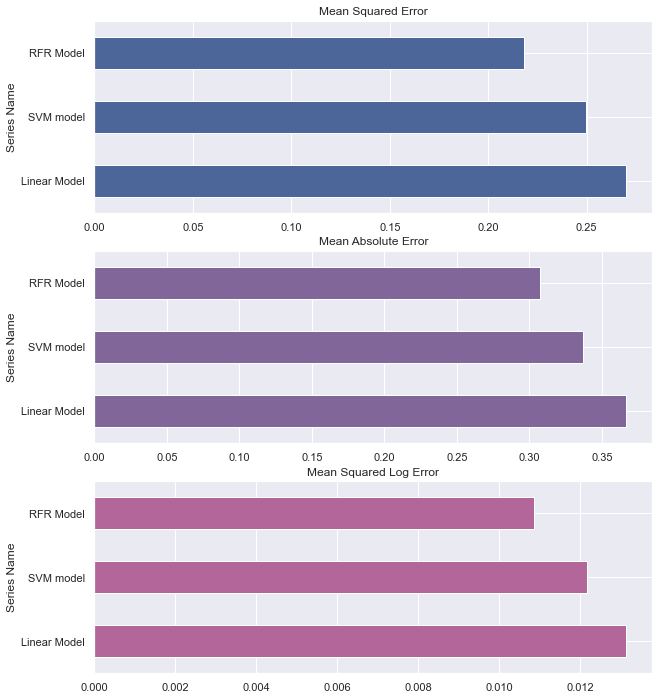

In [129]:
resultsdf.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(3,1,1)
resultsdf['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Mean Squared Error')
plt.subplot(3,1,2)
resultsdf['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.5, 0.4, 0.6, 1), title = 'Mean Absolute Error')
plt.subplot(3,1,3)
resultsdf['Mean Squared Log Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.7, 0.4, 0.6, 1), title = 'Mean Squared Log Error')
plt.show()

=================================================================================================================

# INSIGHTS WE DERIVED

####  1. Average rating of (active) apps on Google Play Store is 4.17.

#### 2. Users prefer to pay for apps that are light-weighted. Thus, a paid app that is bulky may not perform well in the market.

#### 3. Most of the top rated apps are optimally sized between ~2MB to ~40MB - neither too light nor too heavy.

#### 4. Most of the top rated apps are optimally priced between 1 USD to  30 USD - neither too cheap nor too expensive.

#### 5.Medical and Family apps are the most expensive and even extend upto 80 USD.

#### 6. Users tend to download a given app more if it has been reviewed by a large number of people.

#### 7. Health and Fitness apps receive more than 85% positive reviews. Game and Social apps receive mixed feedback - 50% positive and 50% negative.

#### 8. Users are more grim and harsh while reviewing free apps than paid apps.